In [0]:
!pip install tensorflow==1.13.2
!cd '/content/drive/My Drive/Number Plate/darkflow' && pip install .

     |████████████████████████████████| 92.6MB 73kB/s 
     |████████████████████████████████| 3.2MB 44.5MB/s 
     |████████████████████████████████| 368kB 54.7MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3
Processing /content/drive/My Drive/Number Plate/darkflow
  Created wheel for darkflow: filename=darkflow-1.0.0-cp36-cp36m-linux_x86_64.whl size=829352 sha256=6419465132f1bf18bd4037342163f863c00d4c7ff71022b7c2e842434f27fa82
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_39oerg/wheels/d3/42/e2/931f4a184b7be8bde27ce3a360665449cd01d9e0c96b2b79ed
Successfully built darkflow


In [0]:
from darkflow.net.build import TFNet
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob 
import io
import requests
from pprint import pprint
import json
import requests

In [0]:

options = {"pbLoad": "/content/drive/My Drive/Number Plate/yolo-plate.pb", "metaLoad": "/content/drive/My Drive/Number Plate/yolo-plate.meta", "gpu": 0.9}
yoloPlate = TFNet(options)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


Loading from .pb and .meta
Instructions for updating:
Use tf.gfile.GFile.
GPU mode with 0.9 usage


In [0]:
def firstCrop(img, predictions):
    predictions.sort(key=lambda x: x.get('confidence'))
    xtop = predictions[0].get('topleft').get('x')
    ytop = predictions[0].get('topleft').get('y')
    xbottom = predictions[0].get('bottomright').get('x')
    ybottom = predictions[0].get('bottomright').get('y')
    firstCrop = img[ytop:ybottom, xtop:xbottom]
    cv2.rectangle(img,(xtop,ytop),(xbottom,ybottom),(0,255,0),3)
    return firstCrop

In [0]:
def secondCrop(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,0)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    if(len(areas)!=0):
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)
        bounds = cv2.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        secondCrop = img[y:y+h,x:x+w]
    else:
        secondCrop = img
    return secondCrop

In [0]:
df = pd.read_csv("/content/drive/My Drive/Number Plate/indian_license_plates.csv")
df["image_name"] = df["image_name"] + ".jpeg"
# df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [0]:
error = 0
num = 0
for name in glob.glob('/content/drive/My Drive/Number Plate/Indian Number Plates/*')[0:100]:     
  img = cv2.imread(name)
  frame = np.asarray(img)
  predictions = yoloPlate.return_predict(frame)
  if predictions:
      predictions.sort(key=lambda x: x.get('confidence'))
      filename = name.split('/')[-1]
      act_top_x = float(df[df['image_name']==filename]['top_x'])
      act_bottom_x = float(df[df['image_name']==filename]['bottom_x'])
      act_top_y = float(df[df['image_name']==filename]['top_y'])
      act_bottom_y = float(df[df['image_name']==filename]['bottom_y'])

      xtop = predictions[0].get('topleft').get('x')
      ytop = predictions[0].get('topleft').get('y')
      xbottom = predictions[0].get('bottomright').get('x')
      ybottom = predictions[0].get('bottomright').get('y')

      num+=1
      error+= (act_top_x-xtop/608)**2 + (act_bottom_x-xbottom/608)**2 + (act_top_y-ytop/608)**2 + (act_bottom_y-ybottom/608)**2 

rmse = error/num
print('rmse for ',num,' images: ',rmse**0.5)

rmse for  91  images:  0.7475076407124055


500.0 500.0
0.301184433164128 0.6751269035532991 0.4551148225469721 0.6200417536534439
104 341 280 390

0.07462693917655547


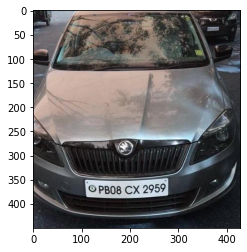

In [0]:
error = 0
num = 0

img = cv2.imread('/content/drive/My Drive/Number Plate/Indian Number Plates/licensed_car221.jpeg')
cv2.resize(img,(608,608))
frame = np.asarray(img)
predictions = yoloPlate.return_predict(frame)
plt.imshow(img)

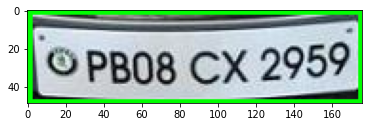

In [0]:
predictions
firstCropImg = firstCrop(frame, predictions)
secondCropImg = secondCrop(firstCropImg)
plt.imshow(firstCropImg)

In [0]:
cv2.imwrite('tp.jpg',secondCropImg)

True

In [0]:
regions = ['in'] # Change to your country
with open('/content/tp.jpg', 'rb') as fp:
    response = requests.post(
        'https://api.platerecognizer.com/v1/plate-reader/',
        data=dict(regions=regions),  
        files=dict(upload=fp),
        headers={'Authorization': 'Token API_TOKEN'})
pprint(response.json())

{'camera_id': None,
 'filename': '1006_NCWxj_tp.jpg',
 'processing_time': 49.323,
 'results': [{'box': {'xmax': 174, 'xmin': 0, 'ymax': 46, 'ymin': 9},
              'candidates': [{'plate': 'pb08cx2959', 'score': 0.837},
                             {'plate': 'pbo8cx2959', 'score': 0.836},
                             {'plate': '0b08cx2959', 'score': 0.831},
                             {'plate': '0bo8cx2959', 'score': 0.83},
                             {'plate': 'pb0bcx2959', 'score': 0.75},
                             {'plate': 'p808cx2959', 'score': 0.75},
                             {'plate': 'pbobcx2959', 'score': 0.749},
                             {'plate': 'p8o8cx2959', 'score': 0.749},
                             {'plate': '0b0bcx2959', 'score': 0.744},
                             {'plate': '0808cx2959', 'score': 0.744}],
              'dscore': 0.88,
              'plate': 'pb08cx2959',
              'region': {'code': 'in', 'score': 0.598},
              'score': 0.83